Simple BB84 Example
====================
Simple BB84 calculations with symmetric Z and X basis choices.
This is used to illustrate how the computation is performed

Author: Darius Bunandar (dariusb@mit.edu)

Unauthorized use and/or duplication of this material without express and
written permission from the author and/or owner is strictly prohibited.


In this notebook, we compute the secret key rate for BB84, assuming that we know
the constraints $\{\Gamma_i\}$ and their values $\{\gamma_i\}$ exactly. 
Here, $\text{Tr}(\rho_{AB} \Gamma_i) = \gamma_i$.

For BB84:

$\{\Gamma_i \} = \{E_X, E_Z\}$, 

$\{\gamma_i \} = \{Q, Q\}$

(The constraint $\text{Tr}(\rho_{AB}) = 1$ has been automatically handled by the code.)

In [1]:
# Initialization Cell
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import numerical_qkd as nQKD
from tqdm import tqdm_notebook as tqdm

MATLAB_LIB_LOC = os.path.join(sys.path[0], '..', 'numerical_qkd', 'matlab_lib')

# Some helpful definitions
sigma_00 = np.array([[1., 0], [0, 0]])
sigma_11 = np.array([[0, 0], [0, 1.]])
sigma_pp = .5*np.array([[1., 1.], [1., 1.]])
sigma_mm = .5*np.array([[1., -1.], [-1., 1.]])
Ez = np.kron(sigma_00, sigma_11) + np.kron(sigma_11, sigma_00)
Ex = np.kron(sigma_pp, sigma_mm) + np.kron(sigma_mm, sigma_pp)
Z0 = sigma_00
Z1 = sigma_11

## Secret key rate from solving $H_{\min}(Z_A|E)$

We compare the numerical results against analytical results:

$r = -\log_2 \left[ \frac{1}{2} \left(1+2\sqrt{(1-Q)Q} \right) \right]$

as proved in Phys. Rev. A 83, 022330 (2011), and to the asymptotic formula

In [3]:
# Numerical method
dim = 2
Gamma = [Ez, Ex]
key_map_povm = [Z0, Z1]

qber = np.linspace(0, .5, 21)
key_opt_primal = np.empty_like(qber)
key_opt_dual = np.empty_like(qber)

Hmin = nQKD.RelativeMinEntropyKeyrate(key_map_povm, [dim, dim])

for i, q in tqdm(enumerate(qber)):
    gamma = np.array([q, q])
    ex_const = {'Gamma': Gamma, 'gamma': gamma}
    Hmin.set_constraints(exact_constraints=ex_const)
    key_opt_primal[i] = Hmin.compute_primal(
        solver='MOSEK')  # change the solver if necessary
    key_opt_dual[i] = Hmin.compute_dual(solver='MOSEK')

# Analytical methods
analytic_qber = np.linspace(np.amin(qber), np.amax(qber), 501)
key = -np.log2(.5*(1+2*np.sqrt(analytic_qber*(1-analytic_qber))))

## Secret key rate from solving $H(Z_A|E)$

We compare the numerical results against the usual BB84 key rate:
    
$r = 1 - h_2(Q)$, where $h_2$ is the binary entropy function.

In [4]:
# Asymptotic numerical method
import matlab.engine

eng = matlab.engine.start_matlab()
eng.addpath(MATLAB_LIB_LOC, nargout=0)
key_opt_primal_asymptotic = np.empty_like(qber)

H = nQKD.RelativeEntropyKeyrate(key_map_povm, [dim, dim])

for i, q in tqdm(enumerate(qber)):
    gamma = np.array([q, q])
    ex_const = {'Gamma': Gamma, 'gamma': gamma}
    H.set_constraints(exact_constraints=ex_const)
    key_opt_primal_asymptotic[i] = H.compute_primal_with_matlab(eng)

eng.quit()
# Analytical method
key_asymptotic = np.array([1-nQKD.bin_entropy(q) for q in analytic_qber])

## Plot the results

We plot the results from previous calculations.

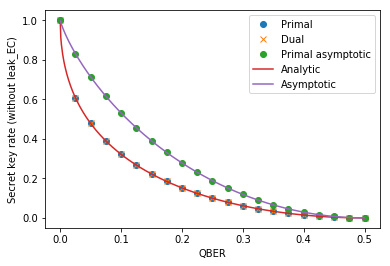

In [6]:
# Plot results
%matplotlib inline

plt.plot(qber, key_opt_primal, 'o', label='Primal')
plt.plot(qber, key_opt_dual, 'x', label='Dual')
plt.plot(qber, key_opt_primal_asymptotic, 'o', label='Primal asymptotic')
plt.plot(analytic_qber, key, label='Analytic')
plt.plot(analytic_qber, key_asymptotic, label='Asymptotic')
plt.xlabel('QBER')
plt.ylabel('Secret key rate (without leak_EC)')
plt.legend()
plt.show()